<a href="https://colab.research.google.com/github/SMunira38/RPDC_withVGG19_30ep/blob/main/RPDC_with_VGG19_M5Dataset(70_15_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import vgg19
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [4]:
!pip install scikit-learn numpy

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [6]:
# Define paths for the dataset
data_dir = '/content/drive/MyDrive/Full Custom Data BRRI'
batch_size = 32

In [7]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [9]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
print("Total images:", len(dataset))
print("Train images:", train_size)
print("Validation images:", val_size)
print("Test images:", test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])



Total images: 1600
Train images: 1120
Validation images: 240
Test images: 240


In [10]:
# Create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
num_classes = len(dataset.classes)
print("Number of classes: ", num_classes)

Number of classes:  8


In [12]:
# Load the pre-trained VGG19 model and modify it for your classification task

model = vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 163MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# Train the model
# Training loop
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy*100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy*100:.2f}%")

print("Finished Training")

Epoch [1/30] - Train Loss: 1.119608 - Train Acc: 62.59% - Val Loss: 0.800163 - Val Acc: 72.92%
Epoch [2/30] - Train Loss: 0.508215 - Train Acc: 83.57% - Val Loss: 0.498709 - Val Acc: 85.00%
Epoch [3/30] - Train Loss: 0.345475 - Train Acc: 89.20% - Val Loss: 0.328649 - Val Acc: 92.08%
Epoch [4/30] - Train Loss: 0.187656 - Train Acc: 94.73% - Val Loss: 0.314296 - Val Acc: 90.00%
Epoch [5/30] - Train Loss: 0.086457 - Train Acc: 96.70% - Val Loss: 0.296370 - Val Acc: 93.33%
Epoch [6/30] - Train Loss: 0.057205 - Train Acc: 98.21% - Val Loss: 0.195079 - Val Acc: 93.75%
Epoch [7/30] - Train Loss: 0.083312 - Train Acc: 96.88% - Val Loss: 0.339388 - Val Acc: 88.75%
Epoch [8/30] - Train Loss: 0.050510 - Train Acc: 98.21% - Val Loss: 0.231058 - Val Acc: 94.58%
Epoch [9/30] - Train Loss: 0.008945 - Train Acc: 99.91% - Val Loss: 0.215227 - Val Acc: 93.75%
Epoch [10/30] - Train Loss: 0.003616 - Train Acc: 100.00% - Val Loss: 0.253729 - Val Acc: 94.58%
Epoch [11/30] - Train Loss: 0.020880 - Train Acc

In [15]:
# Testing loop
test_accuracies = []

model.eval()
correct_predictions_test = 0
total_samples_test = 0

class_correct = [0] * len(train_dataset.dataset.classes)  # Use train_dataset.dataset.classes
class_total = [0] * len(train_dataset.dataset.classes)    # Use train_dataset.dataset.classes

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store predicted and actual labels
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

        # Calculate correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

print(f"Total Correct Predictions on Test Set: {correct_predictions_test} out of {total_samples_test} samples")



Testing Accuracy: 94.58%
Total Correct Predictions on Test Set: 227 out of 240 samples


In [17]:
!pip install tabulate

In [20]:
from tabulate import tabulate
# Print predicted and actual labels in a table
table_data = []
for i in range(len(predicted_labels)):
    table_data.append([i + 1, test_dataset.dataset.classes[predicted_labels[i]], test_dataset.dataset.classes[actual_labels[i]]])

table_headers = ["Sample", "Predicted Label", "Actual Label"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------+-------------------+------------------+
|   Sample | Predicted Label   | Actual Label     |
+==========+===================+==================+
|        1 | Neck blast        | Neck blast       |
+----------+-------------------+------------------+
|        2 | Leaf blast        | Leaf blast       |
+----------+-------------------+------------------+
|        3 | Bacterial Blight  | Bacterial Blight |
+----------+-------------------+------------------+
|        4 | Tungro            | Tungro           |
+----------+-------------------+------------------+
|        5 | Neck blast        | Neck blast       |
+----------+-------------------+------------------+
|        6 | Tungro            | Tungro           |
+----------+-------------------+------------------+
|        7 | Bacterial Blight  | Bacterial Blight |
+----------+-------------------+------------------+
|        8 | Leaf blast        | Leaf blast       |
+----------+-------------------+------------------+
|        9 |

In [22]:
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    accuracy = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0
    table_data.append([class_name, class_correct[i], class_total[i], f"{accuracy:.2f}%"])

table_headers = ["Class", "Correct", "Total", "Accuracy"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+------------------+-----------+---------+------------+
| Class            |   Correct |   Total | Accuracy   |
+==================+===========+=========+============+
| Bacterial Blight |        32 |      32 | 100.00%    |
+------------------+-----------+---------+------------+
| Bakanae Pic      |         7 |       7 | 100.00%    |
+------------------+-----------+---------+------------+
| False Smut       |         7 |       7 | 100.00%    |
+------------------+-----------+---------+------------+
| Leaf blast       |        54 |      56 | 96.43%     |
+------------------+-----------+---------+------------+
| Neck blast       |        75 |      79 | 94.94%     |
+------------------+-----------+---------+------------+
| Node blast       |         3 |       3 | 100.00%    |
+------------------+-----------+---------+------------+
| Sheath Blight    |         6 |      12 | 50.00%     |
+------------------+-----------+---------+------------+
| Tungro           |        43 |      44 | 97.73

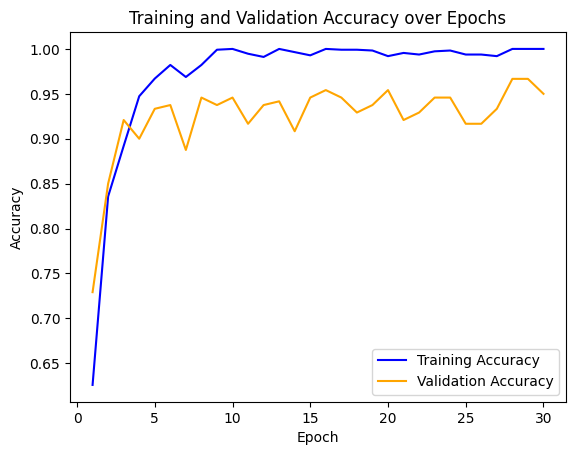

In [27]:
# Plot Training and Validation Accuracy

plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()


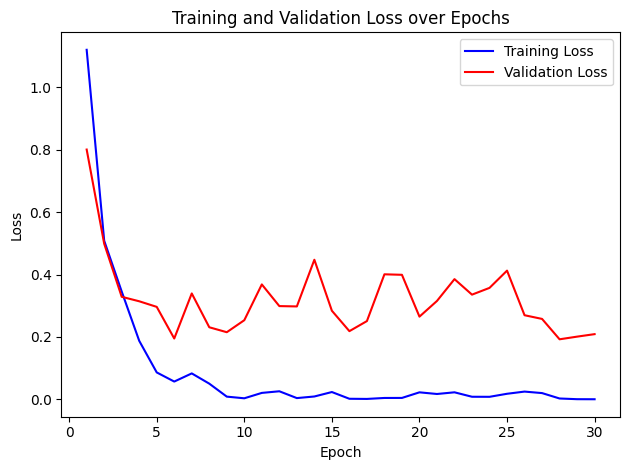

In [28]:
# Plot Training and Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='weighted')

# Create a table with weighted precision, recall, and F1-score
weighted_metrics = [["Weighted", precision, recall, f1]]

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(weighted_metrics, headers=table_headers, tablefmt="grid"))


# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)



+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Weighted |    0.948228 | 0.945833 |   0.943341 |
+----------+-------------+----------+------------+

Confusion Matrix:
[[32  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 1  0  0 54  0  0  1  0]
 [ 2  0  2  0 75  0  0  0]
 [ 0  0  0  0  0  3  0  0]
 [ 0  0  0  6  0  0  6  0]
 [ 1  0  0  0  0  0  0 43]]


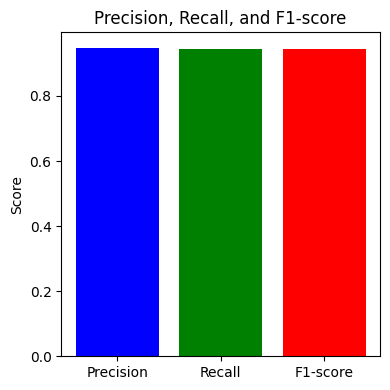

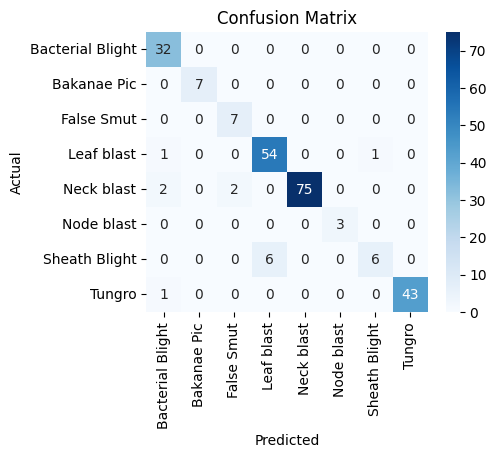

In [94]:
# Plot accuracy graphs

# Plot Precision, Recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1]
plt.figure(figsize=(4, 4))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [79]:
# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average=None)

# Create a table with precision, recall, and F1-score
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    table_data.append([class_name, precision[i], recall[i], f1[i]])

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+------------------+-------------+----------+------------+
| Class            |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Bacterial Blight |    0.888889 | 1        |   0.941176 |
+------------------+-------------+----------+------------+
| Bakanae Pic      |    1        | 1        |   1        |
+------------------+-------------+----------+------------+
| False Smut       |    0.777778 | 1        |   0.875    |
+------------------+-------------+----------+------------+
| Leaf blast       |    0.9      | 0.964286 |   0.931034 |
+------------------+-------------+----------+------------+
| Neck blast       |    1        | 0.949367 |   0.974026 |
+------------------+-------------+----------+------------+
| Node blast       |    1        | 1        |   1        |
+------------------+-------------+----------+------------+
| Sheath Blight    |    0.857143 | 0.5      |   0.631579 |
+------------------+-------------+----------+-----------

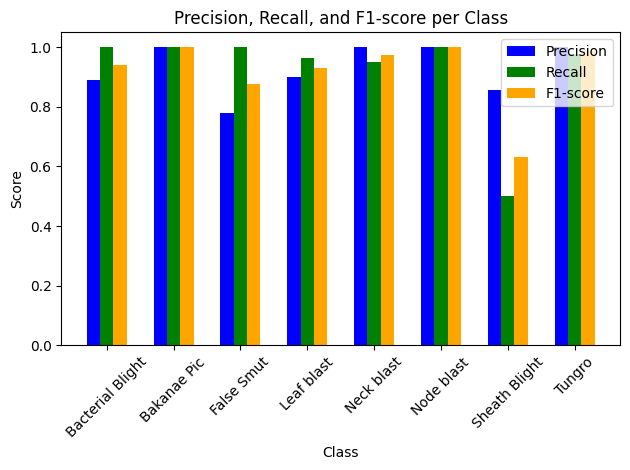

In [82]:
# Plot precision, recall, and F1-score
x = np.arange(len(test_dataset.dataset.classes))
width = 0.2

plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1-score', color='orange')

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(x, test_dataset.dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
pip install torchsummary


In [86]:
from torchsummary import summary
import torchvision.models as models

# ... vgg19...

# Print the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,